<div align="center" style="font-size:28px; font-weight:bold;">
Introduction to Multiple Linear Regression
</div>


Introduction to Multiple Linear Regression

Multiple linear regression extends simple linear regression to situations where a single outcome depends on several predictors. In many real problems a lone feature rarely explains the outcome by itself: for housing prices, square footage matters, but so do location, air quality, neighborhood demographics, access to transit or parking, and other attributes. When we wish to predict a dependent variable $y$ using multiple independent variables $x_1, x_2, \ldots, x_n$, we model their joint contribution with a linear combination plus an intercept:

$$
y = b + m_1 x_1 + m_2 x_2 + \cdots + m_n x_n.
$$

Here, $b$ is the intercept (baseline value when all predictors are zero) and $m_j$ is the effect size of predictor $x_j$ on the outcome, holding the other predictors fixed.

This framework lets us separate and quantify each factor’s association with the target while controlling for the others. Compared to simple linear regression, which captures only the relationship between $y$ and a single $x$, the multiple model can reflect richer structure in the data and typically yields more accurate predictions when additional, relevant predictors are available. In practice, applying multiple linear regression involves choosing meaningful features, fitting the coefficients to minimize the discrepancy between observed and predicted values, and then interpreting those coefficients in context.

In the housing example, we can treat price as $y$ and include features such as size, borough, proximity to subway stations, building amenities, and air quality indices as $x$ variables. Throughout this chapter, we will illustrate these ideas using a StreetEasy apartment dataset from New York City, using it to fit a multiple linear regression model, evaluate its predictive quality, and discuss how to reason about the fitted coefficients.


In [2]:
import pandas as pd

# StreetEasy Dataset

StreetEasy is New York City’s leading real estate marketplace — from studios to high-rises, Brooklyn Heights to Harlem.

In this lesson, you will be working with a dataset that contains a sample of 5,000 rentals listings in Manhattan, Brooklyn, and Queens, active on StreetEasy in June 2016.

It has the following columns:

- rental_id: rental ID
- rent: price of rent in dollars
- bedrooms: number of bedrooms
- bathrooms: number of bathrooms
- size_sqft: size in square feet
- min_to_subway: distance from subway station in minutes
- floor: floor number
- building_age_yrs: building’s age in years
- no_fee: does it have a broker fee? (0 for fee, 1 for no fee)
- has_roofdeck: does it have a roof deck? (0 for no, 1 for yes)
- has_washer_dryer: does it have washer/dryer in unit? (0/1)
- has_doorman: does it have a doorman? (0/1)
- has_elevator: does it have an elevator? (0/1)
- has_dishwasher: does it have a dishwasher (0/1)
- has_patio: does it have a patio? (0/1)
- has_gym: does the building have a gym? (0/1)
- neighborhood: (ex: Greenpoint)
- borough: (ex: Brooklyn)

In [6]:
df = pd.read_csv("data_folder/manhattan.csv")
print(df.head())

   rental_id   rent  bedrooms  bathrooms  size_sqft  min_to_subway  floor  \
0       1545   2550       0.0          1        480              9    2.0   
1       2472  11500       2.0          2       2000              4    1.0   
2       2919   4500       1.0          1        916              2   51.0   
3       2790   4795       1.0          1        975              3    8.0   
4       3946  17500       2.0          2       4800              3    4.0   

   building_age_yrs  no_fee  has_roofdeck  has_washer_dryer  has_doorman  \
0                17       1             1                 0            0   
1                96       0             0                 0            0   
2                29       0             1                 0            1   
3                31       0             0                 0            1   
4               136       0             0                 0            1   

   has_elevator  has_dishwasher  has_patio  has_gym       neighborhood  \
0     

# Multiple Linear Regression: Training Set vs. Test Set

In machine learning, and thus also in multiple linear regression, we must always be aware of how we evaluate the performance of a model. A common mistake is to judge a model only on the data it was trained with, which often leads to overly optimistic results. To avoid this, the dataset is divided into two parts: a training set and a test set.

The training set is the portion of the data we use to fit the model, i.e. to estimate the coefficients of the regression equation. The model “learns” patterns in the relationship between independent variables and the dependent variable from this data. The test set, on the other hand, is kept aside from the very beginning of the process. Its role is to serve as an independent benchmark for evaluating how well the model generalizes to new, unseen data. By comparing the model’s predictions on the test set with the actual outcomes, we can detect whether the model captures general trends or has instead overfitted to the training data.

A common rule of thumb is to allocate about 80% of the available data to the training set and 20% to the test set. This split balances the need for sufficient data to train the model while still leaving enough examples to provide a meaningful evaluation. In practice, tools like `train_test_split` from scikit-learn make this procedure straightforward, with parameters to control the proportions and optionally fix the random seed for reproducibility.

This practice is central to building reliable predictive models. Without a proper test set, we risk creating models that appear highly accurate but fail when confronted with new real-world data. Therefore, distinguishing clearly between training and testing phases is an essential part of the modeling workflow in multiple linear regression.


In [8]:
# 1. Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# 2. Create a DataFrame x with the selected feature columns, and y with the target 'rent'
x = df[['bedrooms', 'bathrooms', 'size_sqft', 'min_to_subway', 'floor', 'building_age_yrs', 
        'no_fee', 'has_roofdeck', 'has_washer_dryer', 'has_doorman', 'has_elevator', 
        'has_dishwasher', 'has_patio', 'has_gym']]

y = df[["rent"]]

# 3. Use train_test_split() to split data into training (80%) and testing (20%) sets, with random_state=6
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=6)

# 4. Print the shapes of x_train, x_test, y_train, and y_test to verify proportions
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2831, 14)
(2831, 1)
(708, 14)
(708, 1)


# Multiple Linear Regression with Scikit-Learn

With the training and test sets prepared, we can now construct a multiple linear regression model using scikit-learn. The procedure is identical to simple linear regression, but instead of a single predictor, we now supply multiple features as explanatory variables. Scikit-learn provides this functionality through the `LinearRegression` class in the `linear_model` module.

The first step is to create a `LinearRegression` object. This object represents the model we want to fit to our training data. By calling its `.fit()` method with the training features and training target values, the algorithm calculates the coefficients and the intercept of the regression equation. Each coefficient corresponds to the contribution of one independent variable to the dependent variable, controlling for the others, while the intercept serves as the baseline when all predictors are zero.

Once the model is fitted, we can generate predictions with the `.predict()` method. Passing the test features as input produces the predicted values for the dependent variable. These predictions are obtained by plugging the coefficients and intercept into the multiple regression equation. Comparing them with the actual test outcomes allows us to assess how well the model generalizes beyond the training data.

In practice, even though multiple features may be available, it is often useful to start with just a subset of predictors to see how the model behaves. For instance, in predicting apartment prices, we could begin by using only two features, then gradually expand to include additional variables. This progressive approach helps in building intuition about the influence of each predictor and the dynamics of the regression model.


In [10]:
# 1. Import LinearRegression from scikit-learn’s linear_model module
from sklearn.linear_model import LinearRegression

# 2. Create a Linear Regression model called mlr and fit it with x_train and y_train
mlr = LinearRegression()
mlr.fit(x_train, y_train)

# 3. Use the model to predict y-values from x_test and store results in y_predict
y_predict = mlr.predict(x_test)

Test for Sonny's appartment

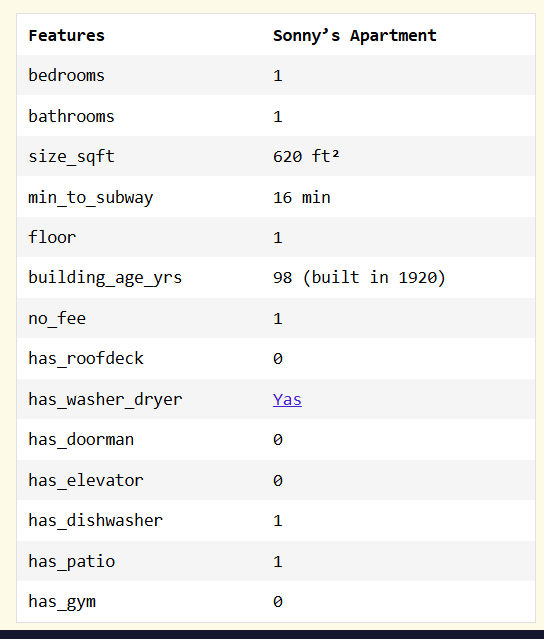



In [11]:
# 4. Test the model on Sonny’s apartment values
# Sonny doesn't have an elevator so the 11th item in the list is a 0
sonny_apartment = [[1, 1, 620, 16, 1, 98, 1, 0, 1, 0, 0, 1, 1, 0]]

predict = mlr.predict(sonny_apartment)

print("Predicted rent: $%.2f" % predict)

Predicted rent: $2393.58


/home/alamanna1/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/tmp/ipykernel_3410/3732337182.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Predicted rent: $%.2f" % predict)


And Sonny is only paying $2,000.

# Multiple Linear Regression: Visualizing Results with Matplotlib

Once a multiple linear regression model is trained and predictions have been generated, it is important to visualize the relationship between the independent variables and the dependent variable. Visualization helps us move beyond raw numbers and coefficients to gain intuitive insight into how different features influence the outcome. In particular, scatterplots are useful for illustrating the distribution of data points and the correspondence between observed and predicted values.

Matplotlib, a widely used Python plotting library, provides straightforward functions for creating 2D scatterplots. By placing one variable on the horizontal axis and another on the vertical axis, we can explore patterns and potential correlations in the data. In the case of regression analysis, the dependent variable (such as rent) is often plotted against one independent variable at a time to better understand how individual features contribute to the model. This can be complemented by overlaying predicted values to see how well the regression model fits the observed data.

Using Matplotlib’s `pyplot.scatter()` function, we can plot data points with adjustable transparency (via the `alpha` parameter) to handle overlapping observations. Labels for axes and descriptive titles are crucial for clarity, ensuring that the visualization communicates the intended message effectively. Finally, calling `plt.show()` renders the plot. Through such graphical inspection, we can assess whether the regression plane captures meaningful patterns or if additional refinement in feature selection and model design might be necessary.


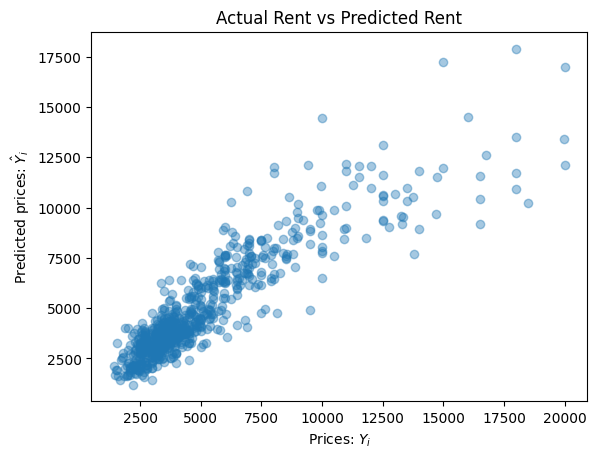

In [13]:
import matplotlib.pyplot as plt

# 1. Create a 2D scatter plot using y_test (actual prices) and y_predict (predicted prices)
plt.scatter(y_test, y_predict, alpha=0.4)

# 2. Add axis labels and a title
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Actual Rent vs Predicted Rent")

# 3. Show the plot
plt.show()


# Multiple Linear Regression Equation

At the core of multiple linear regression lies the mathematical equation that expresses how several independent variables together explain the variation of a dependent variable. The simplest form with two predictors is written as:

$$
y = b + m_1 x_1 + m_2 x_2,
$$

where $b$ is the intercept and $m_1, m_2$ are the coefficients associated with $x_1$ and $x_2$. Expanding to three predictors, the equation becomes:

$$
y = b + m_1 x_1 + m_2 x_2 + m_3 x_3.
$$

In general, multiple linear regression with $n$ predictors is expressed as:

$$
y = b + m_1 x_1 + m_2 x_2 + \cdots + m_n x_n.
$$

Each coefficient $m_j$ measures the change in the dependent variable $y$ associated with a one-unit increase in $x_j$, while holding all other predictors constant. The intercept $b$ represents the baseline value of $y$ when all predictors are zero. Together, the intercept and coefficients define the regression hyperplane that best fits the observed data.

In scikit-learn, after fitting a `LinearRegression` model with `.fit()`, the learned parameters can be accessed directly. The attribute `.coef_` stores the coefficients corresponding to each independent variable, and `.intercept_` stores the baseline intercept. Examining these values is useful not only for prediction but also for interpretation. Large positive coefficients indicate features that push the predicted outcome upwards, while large negative coefficients signal variables that decrease it. For example, if one coefficient is $-1.345$ and another is $0.238$, the first has a stronger (and negative) influence on the dependent variable than the second. By analyzing coefficients, we gain insight into which features carry more explanatory power in determining the outcome.


In [14]:
# Print out the coefficients using .coef_.
# they are 14, like 14 are the x variables
print(mlr.coef_)

[[-302.73009383 1199.3859951     4.79976742  -24.28993151   24.19824177
    -7.58272473 -140.90664773   48.85017415  191.4257324  -151.11453388
    89.408889    -57.89714551  -19.31948556  -38.92369828]]


# Correlations in Multiple Linear Regression

When fitting a multiple linear regression model, each independent variable is assigned a coefficient that quantifies its relationship to the dependent variable. In the Manhattan housing model, we included 14 predictors, resulting in 14 coefficients. Each coefficient indicates both the direction and the strength of association between its corresponding feature and rent, after controlling for all other variables.

For example, a positive coefficient suggests that as the feature increases, rent tends to increase as well. A negative coefficient indicates the opposite: higher values of the feature correspond to lower rents. If a coefficient is close to zero, the variable contributes little to explaining variation in the dependent variable in a linear way. Consider some of the housing features: the number of bathrooms or the presence of an in-unit washer/dryer may have strong positive coefficients, suggesting they raise rental prices, while building age may have a negative coefficient, reflecting depreciation over time.

Interpreting these coefficients becomes clearer when combined with visualization. By plotting each independent variable against rent, we can examine whether the relationships appear positive, negative, or negligible. A rising trend in a scatterplot suggests a positive linear correlation, while a falling trend suggests a negative one. Flat or diffuse patterns imply no clear linear relationship. This graphical exploration is important because it allows us to check the assumptions of linear regression and identify features that may not contribute meaningfully in a linear framework.

Understanding these correlations is essential for both model accuracy and interpretability. Beyond prediction, coefficients and their signs provide insights into the real-world dynamics underlying the data—in this case, the key factors that drive apartment rental prices in Manhattan.


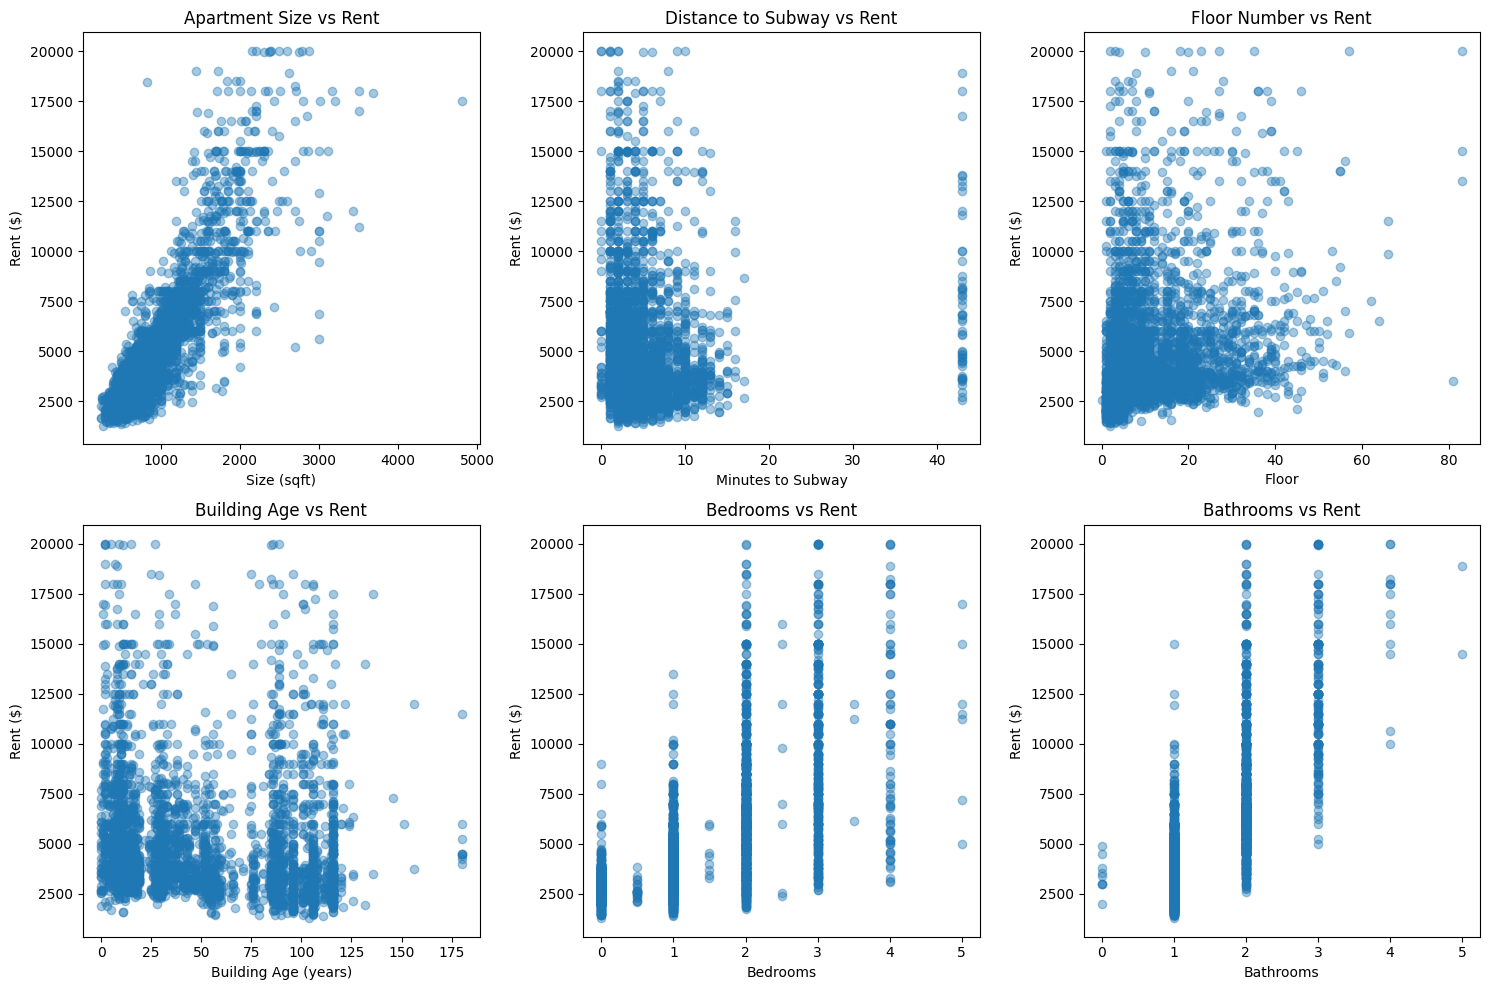

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. size_sqft vs rent
axes[0, 0].scatter(df[['size_sqft']], df[['rent']], alpha=0.4)
axes[0, 0].set_xlabel("Size (sqft)")
axes[0, 0].set_ylabel("Rent ($)")
axes[0, 0].set_title("Apartment Size vs Rent")

# 2. min_to_subway vs rent
axes[0, 1].scatter(df[['min_to_subway']], df[['rent']], alpha=0.4)
axes[0, 1].set_xlabel("Minutes to Subway")
axes[0, 1].set_ylabel("Rent ($)")
axes[0, 1].set_title("Distance to Subway vs Rent")

# 3. floor vs rent
axes[0, 2].scatter(df[['floor']], df[['rent']], alpha=0.4)
axes[0, 2].set_xlabel("Floor")
axes[0, 2].set_ylabel("Rent ($)")
axes[0, 2].set_title("Floor Number vs Rent")

# 4. building_age_yrs vs rent
axes[1, 0].scatter(df[['building_age_yrs']], df[['rent']], alpha=0.4)
axes[1, 0].set_xlabel("Building Age (years)")
axes[1, 0].set_ylabel("Rent ($)")
axes[1, 0].set_title("Building Age vs Rent")

# 5. bedrooms vs rent
axes[1, 1].scatter(df[['bedrooms']], df[['rent']], alpha=0.4)
axes[1, 1].set_xlabel("Bedrooms")
axes[1, 1].set_ylabel("Rent ($)")
axes[1, 1].set_title("Bedrooms vs Rent")

# 6. bathrooms vs rent
axes[1, 2].scatter(df[['bathrooms']], df[['rent']], alpha=0.4)
axes[1, 2].set_xlabel("Bathrooms")
axes[1, 2].set_ylabel("Rent ($)")
axes[1, 2].set_title("Bathrooms vs Rent")

plt.tight_layout()
plt.show()


# Multiple Linear Regression: Evaluating the Model's Accuracy

A crucial part of regression modeling is not just fitting the model but also assessing how well it performs. One widely used technique is **residual analysis**, which examines the differences between actual outcomes and the predictions produced by the model. The residual for each observation is defined as:

$$
e = y - \hat{y},
$$

where $y$ is the observed value and $\hat{y}$ is the predicted value. Ideally, these residuals should be small and randomly distributed, indicating that the model has captured the systematic patterns in the data.

In practice, scikit-learn’s `LinearRegression` class provides a `.score()` method that directly computes the **coefficient of determination**, $R^2$. This statistic quantifies the proportion of variation in the dependent variable explained collectively by all independent variables. Mathematically, it is expressed as:

$$
R^2 = 1 - \frac{u}{v},
$$

where $u$ is the residual sum of squares,

$$
u = \sum (y - \hat{y})^2,
$$

and $v$ is the total sum of squares,

$$
v = \sum (y - \bar{y})^2.
$$

The total sum of squares measures the overall variation in the dependent variable, while the residual sum of squares measures what remains unexplained by the model.

An $R^2$ value close to 1.0 indicates that the model explains most of the variability in the data, whereas values near 0 imply poor explanatory power. Interestingly, $R^2$ can even be negative if the model performs worse than a simple mean-based prediction. As a rule of thumb, values above 0.70 are often regarded as strong in applied contexts, though acceptable thresholds depend on the domain and the complexity of the problem.

For example, if we fit a model predicting rent using only square footage and number of bedrooms and obtain an $R^2$ of 0.72, we can say that these two variables together explain 72% of the variation in rent. If we then add building age and the $R^2$ rises to 0.95, this indicates a significant improvement, meaning the three predictors jointly explain 95% of the variation. Such evaluations help us understand not only how accurate our model is but also whether adding more features genuinely improves predictive performance.


Train score:
0.7725460559817883
Test score:
0.8050371975357655


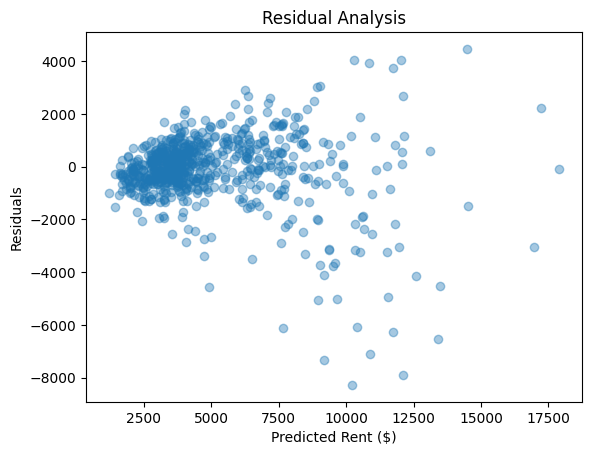

In [24]:
# 1. Use .score() to find R² for the training set
print("Train score:")
print(mlr.score(x_train, y_train))

# 2. Use .score() to find R² for the testing set
print("Test score:")
print(mlr.score(x_test, y_test))

# Residual analysis plot
residuals = y_predict - y_test
plt.scatter(y_predict, residuals, alpha=0.4)
plt.title('Residual Analysis')
plt.xlabel("Predicted Rent ($)")
plt.ylabel("Residuals")
plt.show()


In [30]:
features = [
    'bedrooms', 'bathrooms', 'size_sqft', 'min_to_subway', 'floor',
    'building_age_yrs', 'no_fee', 'has_roofdeck', 'has_washer_dryer',
    'has_doorman', 'has_elevator', 'has_dishwasher', 'has_patio', 'has_gym'
]

def evaluate_borough(csv_name, borough_title):
    # Load data
    df = pd.read_csv("data_folder/" + csv_name)

    # Features and target
    x = df[features]
    y = df[['rent']]

    # Train/test split
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, train_size=0.8, test_size=0.2, random_state=6
    )

    # Model fit
    mlr = LinearRegression()
    mlr.fit(x_train, y_train)

    # Scores
    train_score = mlr.score(x_train, y_train)
    test_score  = mlr.score(x_test, y_test)

    print(f"{borough_title} — Train R²: {train_score:.12f}")
    print(f"{borough_title} — Test  R²: {test_score:.12f}")

    # Residual analysis
    y_pred = mlr.predict(x_test)
    residuals = y_pred - y_test

    plt.scatter(y_pred, residuals, alpha=0.4)
    plt.title(f"{borough_title} Residual Analysis")
    plt.xlabel("Predicted Rent ($)")
    plt.ylabel("Residuals")
    plt.axhline(0, linestyle="--")
    plt.show()

Brooklyn — Train R²: 0.613221453798
Brooklyn — Test  R²: 0.584349923873


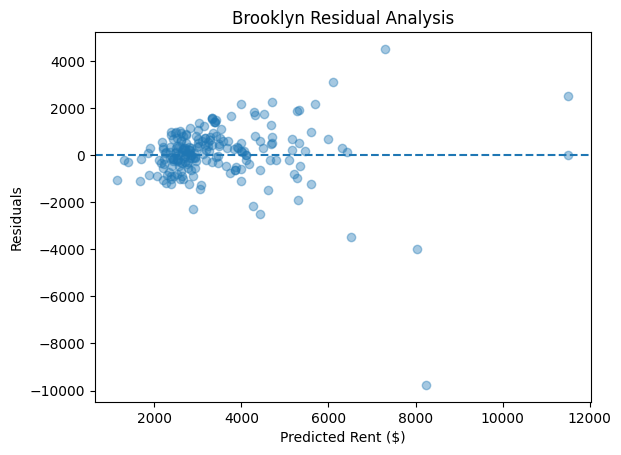

In [31]:
# Evaluate Brooklyn
evaluate_borough("brooklyn.csv", "Brooklyn")

Queens — Train R²: 0.665836031009
Queens — Test  R²: 0.665170319781


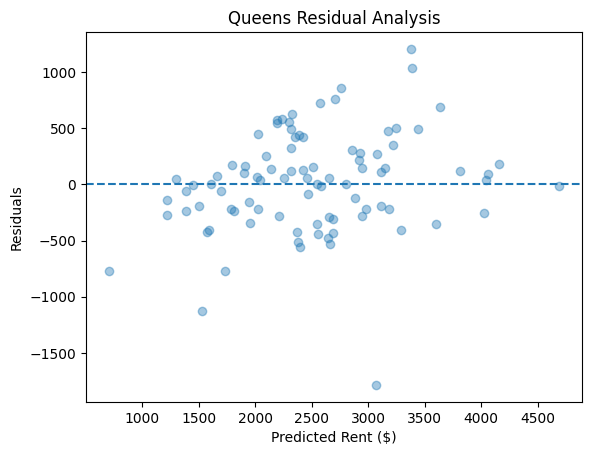

In [32]:
# Evaluate Queens
evaluate_borough("queens.csv", "Queens")